# Dog Breed Recognition - Cotella Vincent Leroy Malo Chaix Gabriel Cha Elvin

# Import

In [3]:
#visualization
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

# Loading data 

In [4]:
# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


# datasets
trainset = torchvision.datasets.ImageFolder("dog_dataset/train", transform = transforms)
validset = torchvision.datasets.ImageFolder("dog_dataset/valid", transform = transforms)
testset = torchvision.datasets.ImageFolder("dog_dataset/test", transform = transforms)

#batches
batch_size = 128

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

# Visualisation d'un échantilon de Données d'Entraînement

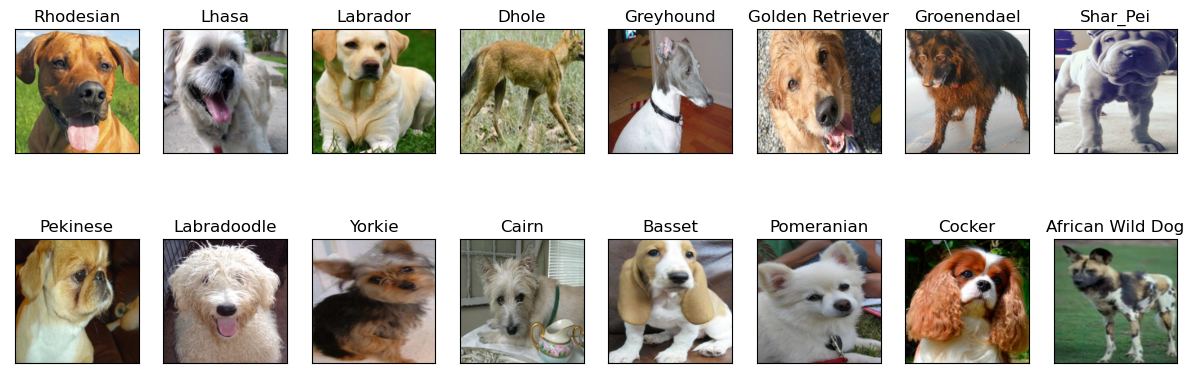

In [6]:
# Get a batch of training data
images, labels = next(iter(trainloader))
images, labels = images.numpy(), labels.numpy()

# Plot the images
fig = plt.figure(figsize=(15, 5))
for i in range(int(batch_size / 8)):
    ax = fig.add_subplot(2, int(batch_size / 16), i + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i], (1, 2, 0)), cmap='gray')
    ax.set_title(trainset.classes[labels[i]])


# Information sur le data set 

In [37]:
# Single batch
print("number of train batches : ", len(trainloader))
print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))
print("Classes : ", trainset.classes)

number of train batches :  63
number of validation batches :  6
Size of test batches :  6
Classes :  ['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu')

if my_gpu:
    print(f"My device: {torch.cuda.get_device_name(0)}")

# Load pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# Add a custom fully connected layer
num_classes = len(trainset.classes)  # Adjust this based on your dataset
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

print("The new layer is:", model.fc)

# Move the model to the appropriate device
model = model.to(device)


Train on gpu: False
The new layer is: Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=70, bias=True)
  (4): LogSoftmax(dim=1)
)


In [12]:
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = lr)

In [13]:
#format class

class color_formats:
    """
    Simple color formating:
    Variables:
        >OKCYAN - cyan printing.
        >Bold - bold printing.
        >UNDERLINE - underline printing.
    """
    OKCYAN = '\033[96m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [14]:
def train_loop(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_model_name,
          max_epochs_stop=3,
          num_epochs=20,
          num_epochs_report=1):
    """Train a neural network Model
    Args
    --------
        >model (Pytorch nn model): The neural network for the training process.  
        >criterion (Pytorch loss function): Initialize the loss function.
        >optimizer (Pytorch optimizer): Use an optimizer to compute gradients to update the weights.
        >train_loader (Pytorch dataloader): training dataloader to iterate through.
        >valid_loader (Pytorch dataloader): validation dataloader used for early stopping.
        >save_model_name (str): file path to save the model state dict, file name ends with 'pt.'.
        >max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping.
        >num_epochs (int): maximum number of training epochs if the early stopping is not activated.
        >num_epochs_report (int): frequency of epochs to print training reports.
    
    outputs
    --------
        >model (PyTorch model): Trained neural networks with best weights.
        >history (DataFrame): History of train and validation loss and accuracy.
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf  

    valid_max_acc = 0
    history = []

    # Number trained epochs  (while using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'{color_formats.BOLD + color_formats.UNDERLINE}Training activated:{color_formats.ENDC}\n')

    overall_start = timer()

    # Start of loop
    for epoch in range(num_epochs):

        # Track of training and validation loss for each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set model to train
        model.train()
        
        #start timer
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Put the data in the gpu
            if my_gpu:
                data, target = data.to(device), target.to(device)

            # Remove past gradients
            optimizer.zero_grad()
            # Predicted outputs as log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target.long())
            loss.backward()

            # Update the weights
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Training progress tracker
            print(
                f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')


        # Start validation after training loops ends.
        else:
            model.epochs += 1

            # Deactivate the gradient tracking. 
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Put the data in the gpu
                    if my_gpu:
                        data, target = data.to(device), target.to(device)

                    # Predicted outputs as log probabilities
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target.long())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate accuracy of validation set
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results for the num_epochs_report that was set
                if (epoch + 1) % num_epochs_report == 0:
                    print(
                        f'\n\nEpoch: {color_formats.BOLD}{epoch+1}{color_formats.ENDC} \tTraining Loss: {color_formats.BOLD}{train_loss:.4f}{color_formats.ENDC} \tValidation Loss: {color_formats.BOLD}{valid_loss:.4f}{color_formats.ENDC}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {color_formats.BOLD}{100 * train_acc:.2f}%{color_formats.ENDC}\t Validation Accuracy: {color_formats.BOLD}{100 * valid_acc:.2f}%{color_formats.ENDC}\n'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_model_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch + 1

                # Otherwise count all consecutive epochs with no improvement.
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\n\n{color_formats.OKCYAN}Early stopping activated!{color_formats.ENDC}\nthe validation loss has not improved for {max_epochs_stop} epochs.\n\n{color_formats.BOLD + color_formats.UNDERLINE}End of training report:{color_formats.ENDC}\n\n\t-Total epochs: {epoch+1} \n\t-Best epoch: {color_formats.BOLD}{best_epoch}{color_formats.ENDC} \n\t-loss: {color_formats.BOLD}{valid_loss_min:.2f}{color_formats.ENDC} \n\t-accuracy: {color_formats.BOLD}{100 * valid_best_acc:.2f}%\n{color_formats.ENDC}'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_model_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # History update
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history


    # Record overall time and print out Report
    total_time = timer() - overall_start
    print(
        f'\nBest epoch is epoch #{best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # History update
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

# Running model

In [15]:
# Running the model
model, history = train_loop(
    model,
    criterion,
    optimizer,
    trainloader,
    validloader,
    save_model_name="./model1.pt",
    max_epochs_stop=20,
    num_epochs=100,
    num_epochs_report=5)

Training activated:

Epoch: 5	100.00% complete. 249.93 seconds elapsed in epoch.

Epoch: 5 	Training Loss: 0.5868 	Validation Loss: 0.6023
		Training Accuracy: 82.31%	 Validation Accuracy: 91.00%

Epoch: 10	100.00% complete. 249.86 seconds elapsed in epoch.

Epoch: 10 	Training Loss: 0.4244 	Validation Loss: 0.6156
		Training Accuracy: 86.65%	 Validation Accuracy: 90.86%

Epoch: 15	100.00% complete. 201.40 seconds elapsed in epoch.

Epoch: 15 	Training Loss: 0.3600 	Validation Loss: 0.6301
		Training Accuracy: 88.18%	 Validation Accuracy: 92.14%

Epoch: 20	100.00% complete. 189.33 seconds elapsed in epoch.

Epoch: 20 	Training Loss: 0.2892 	Validation Loss: 0.6820
		Training Accuracy: 90.81%	 Validation Accuracy: 91.29%

Epoch: 25	100.00% complete. 175.71 seconds elapsed in epoch.

Epoch: 25 	Training Loss: 0.2674 	Validation Loss: 0.6964
		Training Accuracy: 91.29%	 Validation Accuracy: 91.14%



Early stopping activated!
the validation loss has not improved for 20 epochs.

End of tra

C:\Users\elvin\AppData\Local\Temp\ipykernel_24068\3281491968.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_name))


# models logs in detail over time of training.

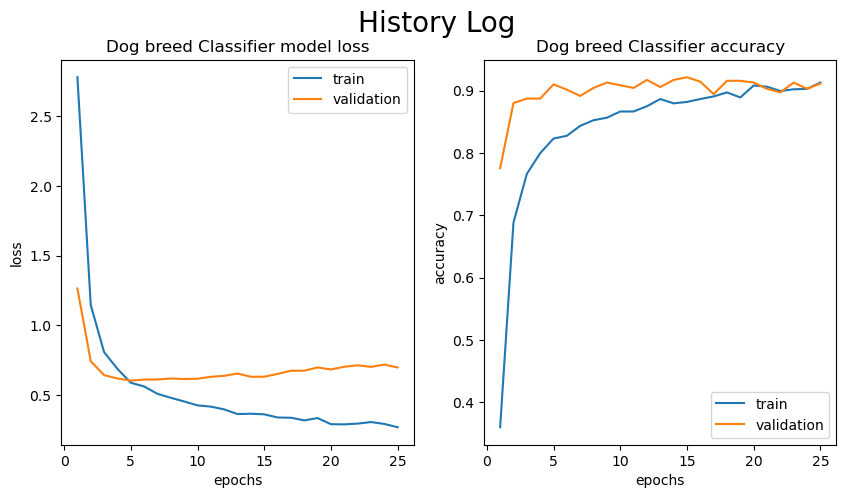

In [16]:
history.index = [idx for idx in range(1, history.shape[0]+1)] #from first epoch
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)
#ethnicity model log

axs[0].plot(history["train_loss"], label = "train")
axs[0].plot(history["valid_loss"], label = "validation")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title('Dog breed Classifier model loss')

axs[1].plot(history["train_acc"], label = "train")
axs[1].plot(history["valid_acc"], label = "validation")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].set_title('Dog breed Classifier accuracy')


plt.show()

# lets see what breed the algorithm struggle with 

In [38]:
def test_report(class_acc, acc, num_worst=5):
    """
    Args:
        class_acc (dict): Accuracy per class, with non-existent targets in the test set set to NaN.
        acc (float): Overall accuracy.
        num_worst (int): Number of classes with the worst accuracy to display.
    
    Output:
        Report of test performance showing the worst accuracies.
    """
    # Filter out NaN values and sort classes by accuracy in ascending order
    sorted_class_acc = {k: v for k, v in sorted(class_acc.items(), key=lambda item: item[1]) if not np.isnan(v)}
    
    print(f"{color_formats.BOLD + color_formats.UNDERLINE}Test Accuracy Report{color_formats.ENDC}")
    
    # Display the classes with the worst accuracies
    worst_classes = list(sorted_class_acc.items())[:num_worst]
    for key, value in worst_classes:
        print(f"Class {trainset.classes[key]} has achieved {color_formats.BOLD}{value}%{color_formats.ENDC} accuracy\n")
    
    #print(f"Overall accuracy: {color_formats.BOLD}{acc}%{color_formats.ENDC}")

# Supposons que vous ayez les résultats d'Accuracy_report
class_acc, acc = Accuracy_report(loader=testloader, model=model, n_classes=len(trainset.classes))

# Appel de la fonction test_report pour afficher les pires performances
test_report(class_acc, acc, num_worst=5)


Test Accuracy Report
Class Bulldog has achieved 50.0% accuracy

Class Dingo has achieved 60.0% accuracy

Class Boston Terrier has achieved 70.0% accuracy

Class Bull Terrier has achieved 70.0% accuracy

Class American Spaniel has achieved 80.0% accuracy

Overall accuracy: 94.43%


# Visualisation of the prediction

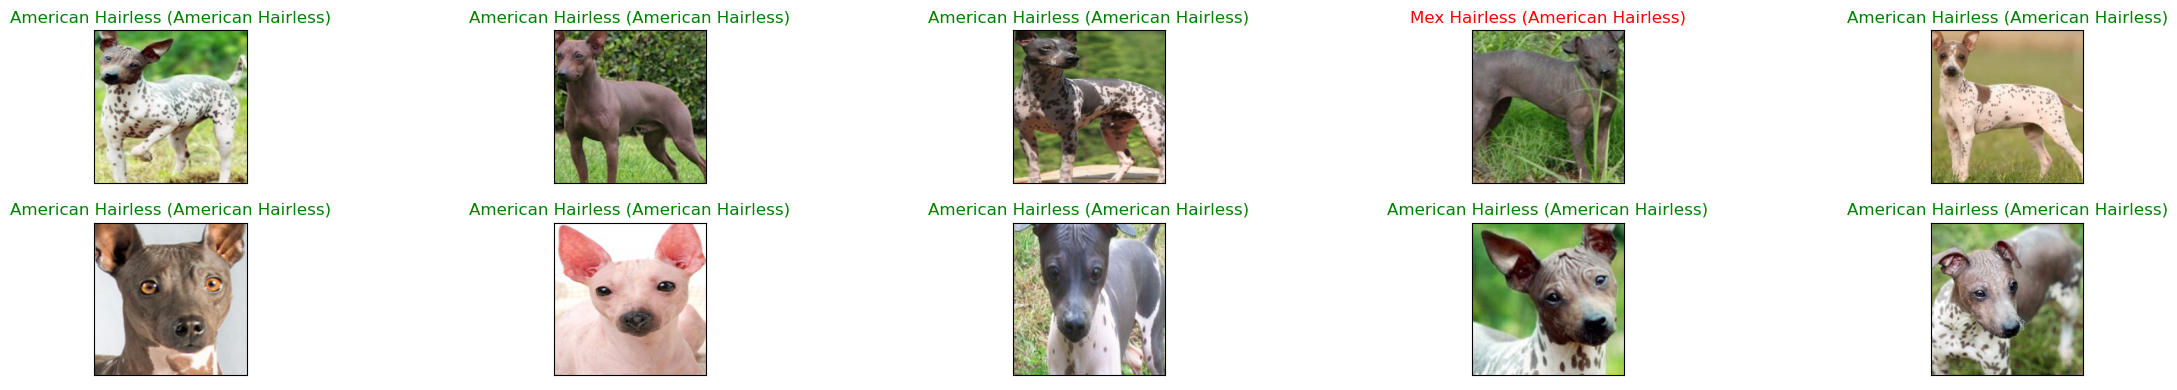

In [23]:

target_class_index = 3

# Filtrer les images et labels pour la classe cible
target_images = []
target_labels = []

dataiter = iter(testloader)
for _ in range(len(testloader)):
    images, labels = next(dataiter)
    # Filtrer les images pour la classe cible
    for img, lbl in zip(images, labels):
        if lbl == target_class_index:
            target_images.append(img)
            target_labels.append(lbl)
    if len(target_images) >= int(batch_size / 8):  # Limiter le nombre d'images affichées
        break

# Convertir en tenseurs et déplacer vers CPU pour l'affichage
target_images = torch.stack(target_images).cpu().numpy()
target_labels = torch.tensor(target_labels).cpu().numpy()

# Obtenir les prédictions pour la classe cible
preds = np.squeeze(model(torch.tensor(target_images).to(device)).data.max(1, keepdim=True)[1].cpu().numpy())

# Plot des images avec labels prédits et vrais
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(len(target_images)):
    ax = fig.add_subplot(2, int(len(target_images) / 2), idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(target_images[idx].transpose(1, 2, 0)), cmap='gray')
    ax.set_title("{} ({})".format(trainset.classes[preds[idx]], trainset.classes[target_labels[idx]]),
                 color=("green" if preds[idx] == target_labels[idx] else "red"))
plt.tight_layout()



### as we can see the algorithm struggle with breed that have a lot of similarities 

# How the algorithm is dealing with image from external source ? 

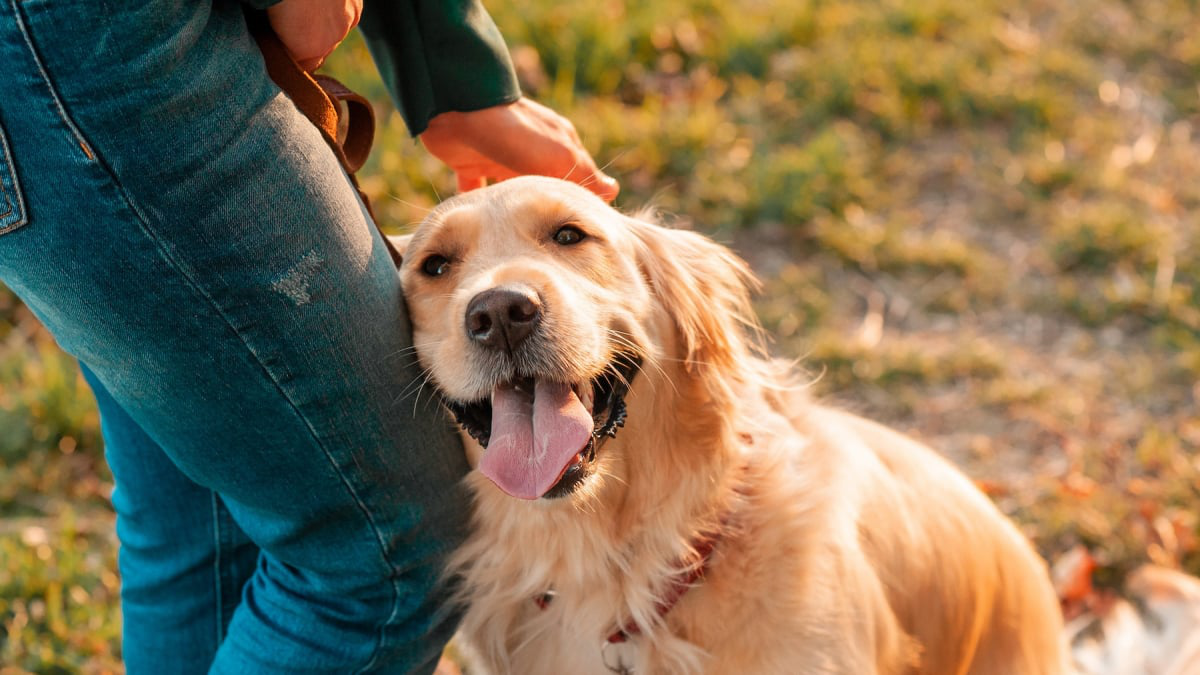

In [35]:
url = "https://www.woopets.fr/assets/img/042/264/1200x675/nom-chien-a.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [36]:
def predictor(img, n=5):
    img = transforms(img)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img = img.unsqueeze(0).to(device)
    
    pred = int(np.squeeze(model(img).data.max(1, keepdim=True)[1].cpu().numpy()))
    pred = trainset.classes[pred]
    
    preds = torch.from_numpy(np.squeeze(model(img).data.cpu().numpy()))
    top_preds = torch.topk(torch.exp(preds), n)
    top_preds = dict(zip([trainset.classes[i] for i in top_preds.indices], [f"{round(float(i)*100,2)}%" for i in top_preds.values]))
    
    return pred, top_preds

# Utilisation
my_prediction, top_predictions = predictor(img, n=5)
print(my_prediction)
print(top_predictions)

Golden Retriever
{'Golden Retriever': '61.71%', 'Cocker': '28.05%', 'Beagle': '1.89%', 'Labrador': '1.6%', 'Clumber': '1.13%'}


### the algorithm predict at 61% that the dog is a golden retriever wich is correct 